In [1]:
import cv2 
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
import joblib

### Feature Extraction
Extraer los features de las imagenes de la carpeta utilizando opencv con SIFT.

```keypoints, descriptors = sift.detectAndCompute(gray, None)```
- keypoints almacena las coordenadas (x,y) de cada keypoint de la imagen (esquinas, manchas, cambios bruscos de intensidad, etc).
- descriptors almacena los descriptores para cada keypoint de esa imagen (128 descriptores).

Como son muchos datos y el vector de SIFT es grande podemos utilizar reducción de dimensionalidad. Hacemos un análisis para saber cuantas componentes usamos en el PCA. Utilizamos menos imagenes para ese analisis.

Total images:  997
Componentes: 10 varianza acumulada: 0.571979.
Componentes: 20 varianza acumulada: 0.734423.
Componentes: 30 varianza acumulada: 0.818874.
Componentes: 40 varianza acumulada: 0.869553.
Componentes: 50 varianza acumulada: 0.906059.
Componentes: 60 varianza acumulada: 0.932594.
Componentes: 70 varianza acumulada: 0.951752.
Componentes: 80 varianza acumulada: 0.966586.
Componentes: 90 varianza acumulada: 0.977817.
Componentes: 100 varianza acumulada: 0.986567.
Componentes: 110 varianza acumulada: 0.993040.
Componentes: 120 varianza acumulada: 0.997689.


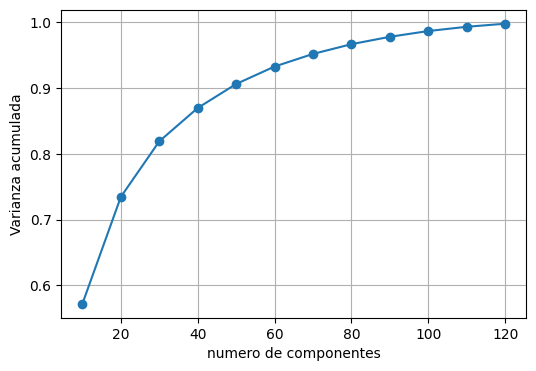

In [ ]:
sift = cv2.SIFT_create()
all_descriptors = []

tiny_dataset_path = "../data/fashion_small_1000/" 
#Extraer descriptores
image_filenames = []
for filename in os.listdir(tiny_dataset_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(tiny_dataset_path, filename)
        image_filenames.append(full_path)

total = 0
for file_path in image_filenames: 
    total += 1
    img = cv2.imread(file_path)
    if img is None:
        continue
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    if descriptors is not None:
        all_descriptors.append(descriptors)


print("Total images: ", total)
X = np.vstack(all_descriptors)  # Unir vectores en una matriz

# Aplicar pca
explained_variances = []
components_range = range(10, 130, 10)  # 10 a 120, pasos de 10

for n in components_range:
    pca = PCA(n_components=n)
    pca.fit(X)
    explained_var = np.sum(pca.explained_variance_ratio_)
    print(f"Componentes: {n} varianza acumulada: {explained_var:f}.")
    explained_variances.append(explained_var)

# Graficar
plt.figure(figsize=(6, 4))
plt.plot(components_range, explained_variances, marker='o')
plt.xlabel('numero de componentes')
plt.ylabel('Varianza acumulada')
plt.grid(True)
plt.show()

Extraer descriptores del dataset

In [7]:
def generate_descriptors(dataset_path, n_components_pca):
    sift = cv2.SIFT_create()
    descriptor_dict = {}

    for filename in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, filename)
        if os.path.isfile(file_path):
            img = cv2.imread(file_path)
            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            keypoints, descriptors = sift.detectAndCompute(gray, None)

            if descriptors is not None:
                key = os.path.splitext(filename)[0]
                descriptor_dict[key] = descriptors.astype(np.float32)

    print(f"Descriptores extraidos de {len(descriptor_dict)} imagenes")

    # Combinar descriptores para entrenar pca
    all_descriptors = np.vstack(list(descriptor_dict.values()))
    pca = PCA(n_components=n_components_pca)
    pca.fit(all_descriptors) #entrenar pca

    # Aplicar PCA a los descriptores
    derscriptors_pca = {}
    for key, descriptors in descriptor_dict.items():
        derscriptors_pca[key] = pca.transform(descriptors).astype(np.float32)

    # retorna diccionario, los keys son los numeros de las imagenes y los values arrays con los descriptores reducidos
    return derscriptors_pca 

In [ ]:
# CAMBIAR PATH A DONDE TIENES EL DATASET COMPLETO GUARDADO, O A LOS CHIQUITOS
dataset_path = "C:/Users/davie/Downloads/fashion_small/images/" 

In [ ]:
pca_model_path = "../Image_descriptors/pca_model.pkl"
descriptors_pca_path = "../Image_descriptors/descriptors_pca.npz"

if os.path.exists(pca_model_path) and os.path.exists(descriptors_pca_path):
    # Cargar descriptores y pca desde los archivos
    pca = joblib.load(pca_model_path)
    reduced_descriptors = np.load("descriptors_pca.npz", allow_pickle=True)
    print(f"{len(reduced_descriptors)} descriptores cargados")
else: 
    # Generar descriptores por primera vez
    reduced_descriptors = generate_descriptors(dataset_path, 70) # 70 componentes de acuerdo al analisis
    np.savez_compressed("descriptors_pca.npz", **reduced_descriptors) # Guardar descriptores del pca
    joblib.dump(pca, "pca_model.pkl") # Guardar modelo pca

print(f"Varianza retenida: {pca.explained_variance_ratio_.sum():.2%}")

Descriptores extraidos de 44327 imagenes
Varianza retenida: 95.10%


In [38]:
# TODO: Para el dataset completo realizar analisis de n_clusters para el KMEANS

filenames = []
descriptors = []
for key, value in reduced_descriptors.items():
    filenames.append(key)
    descriptors.append(value)

# K-Means para construir el diccionario visual
kmeans = KMeans(n_clusters=250, random_state=0, n_init="auto")
kmeans.fit(np.vstack(descriptors))

# Construcción de histogramas por imagen
all_histograms = []
for d in descriptors:
    histogram = np.zeros(kmeans.n_clusters, dtype=int)

    if d is not None:
        cluster_assignments = kmeans.predict(d)
        for idx in cluster_assignments:
            histogram[idx] += 1

    # Normalización
    histogram = histogram.astype(float)
    histogram /= np.sum(histogram) if np.sum(histogram) > 0 else 1
    all_histograms.append(histogram)

In [39]:
def create_query_histogram(image_path, kmeans, pca): 
    sift = cv2.SIFT_create()
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None:
        print(f"No keypoints found in image: {image_path}")
        return np.zeros(kmeans.n_clusters, dtype=float)

    descriptors_reduced = pca.transform(descriptors)
    histogram = np.zeros(kmeans.n_clusters, dtype=int)

    if descriptors_reduced is not None:
        cluster_assignments = kmeans.predict(descriptors_reduced)
        for idx in cluster_assignments:
            histogram[idx] += 1

    # Normalización
    histogram = histogram.astype(float)
    histogram /= np.sum(histogram) if np.sum(histogram) > 0 else 1
    return histogram

Aplicar ponderación TF-IDF

- Los documentos son las imagenes
- Los words son los clusters, cada cluster es un visual word

![Visual Histogram](../imgs/visual_hist.png)



Para la imagen de la bici tengo un histograma, cuento cuantas veces aparece cada descriptor en esa imagen de la bici.

El tf seria algo como [5/7, 1/7, 1/7, 0/7] donde 7 es el total de términos en la imagen (total de palabras en el documento)
- tf = $\frac{n_{id}}{n_d}$
- idf = $log(\frac{N}{n_i})$

El df seria el número de imagenes donde el visual word i aparece (al menos una vez). *la palabra x aparece en y documentos*

![TF-IDF](../imgs/tf_idf.png)

Calcular Document frequency, ejemplo:
```py
histograms = np.array([
  [3, 0, 1],   # Imagen 1
  [0, 2, 0],   # Imagen 2
  [1, 0, 5],   # Imagen 3
])
```
- Visual word 0 aparece en las imagenes 1 y 3. Image 1 and 3.
- Visual word 2 aparece en la imagen 2.
- Visual word 3 aparece en las imagenes 1 y 3.

```histograms > 0``` me da una matriz booleana. Si un visual word aparece en el documento (cluster) seria True:
```py
[
  [True,  False, True ],
  [False, True,  False],
  [True,  False, True ]
]
```
Luego con ```np.sum()```  sumo veo en cuantos documentos aparece cada visual word (cuenta los True).


In [40]:
N = len(descriptors) #equivalente a la cantidad de imagenes 
all_histograms = np.array(all_histograms, dtype=np.float32) 

tf = []
#for hist in all_histograms:
#    tf.append(hist / np.sum(hist)) #frecuencia de cada termino (descriptor) en el histograma[i]
tf = all_histograms  

idf = []
for i in range(kmeans.n_clusters): #i es el índice del visual word
    df = np.sum(all_histograms[:, i] > 0) # all_histograms > 0 me da una matriz de booleanos (si aparece el word o no en el doc)
    idf.append(np.log(N / (df + 1e-8))) # Sumo constante chiquita para evitar división por cero

idf_np = np.array(idf, dtype=np.float32)
tf_idf = tf * idf_np
print(tf_idf.shape) # (num_imagenes, num_clusters). tf_idf[i][j] es la importancia del visual word j en la imagen i

(44327, 250)


### KNN Secuencial



In [41]:
def show_top_similar_images(top_k, query_image_path, dataset_path):
    plt.figure(figsize=(18, 5))

    # Mostrar imagen de la query
    img_query = cv2.imread(query_image_path)
    img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(top_k) + 1, 1)
    plt.imshow(img_query)
    plt.title("Query")
    plt.axis("off")

    # Mostrar las imágenes similares
    for rank, (sim, filename) in enumerate(top_k, start=2):
        img_path = os.path.join(dataset_path, filename + ".jpg")  # Ajusta extensión si es diferente
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(top_k) + 1, rank)
        plt.imshow(img)
        plt.title(f"Sim: {sim:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()



Top imágenes más similares:
5730: similitud = 0.9912
39632: similitud = 0.3887
47670: similitud = 0.3777
57496: similitud = 0.3729
15405: similitud = 0.3722
13689: similitud = 0.3657
22236: similitud = 0.3649
4641: similitud = 0.3639
35392: similitud = 0.3637
5002: similitud = 0.3557


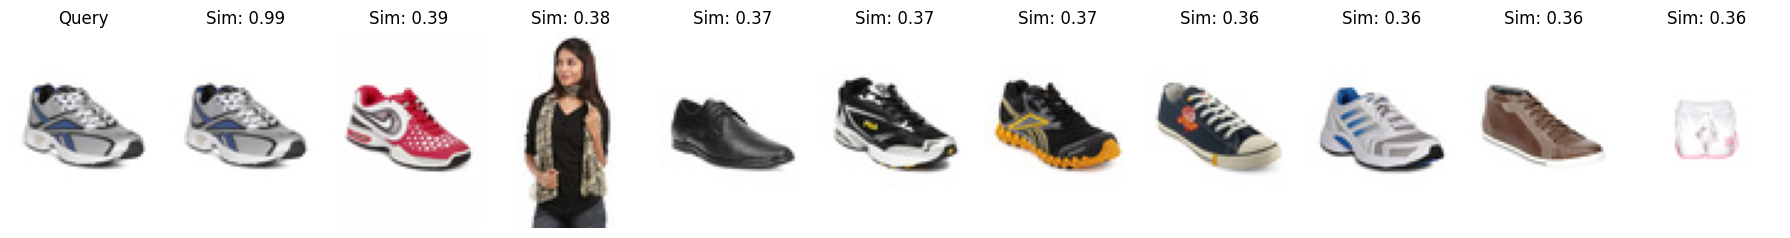

In [42]:
import heapq
image_path = "C:/Users/davie/Downloads/fashion_small/images/5730.jpg" # imagen query
query_hist = create_query_histogram(image_path, kmeans, pca)

# Aplicar TF-IDF a la query
query = query_hist * idf_np
k = 10  # top-k resultados

heap = []

for i, hist in enumerate(all_histograms):
    dot = np.dot(query, hist)
    norm_query = np.linalg.norm(query)
    norm_hist = np.linalg.norm(hist)

    cosine_sim = 0
    if norm_query != 0 and norm_hist != 0:
        cosine_sim = dot / (norm_query * norm_hist)

    heapq.heappush(heap, (cosine_sim, filenames[i]))  # usar nombre directamente

    if len(heap) > k:
        heapq.heappop(heap)  # eliminar el menos similar

# Mostrar resultados en orden descendente de similitud 
top_k = sorted(heap, reverse=True)

print("\nTop imágenes más similares:")
for sim, name in top_k:
    print(f"{name}: similitud = {sim:.4f}")

# Mostrar la imagen de la query
show_top_similar_images(top_k, image_path, dataset_path)

### KNN con indexación invertida